<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/nbs/02_train_pascal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# What GPU do we have ?
! nvidia-smi

Fri Sep 11 06:33:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Standard imports & setup**

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

In [3]:
# install dependencies
! pip install pytorch-lightning wandb --quiet
! pip install git+https://github.com/albumentations-team/albumentations --quiet

     |████████████████████████████████| 409kB 4.8MB/s 
     |████████████████████████████████| 1.4MB 15.3MB/s 
     |████████████████████████████████| 2.8MB 31.8MB/s 
     |████████████████████████████████| 276kB 38.2MB/s 
     |████████████████████████████████| 829kB 41.7MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 122kB 60.3MB/s 
     |████████████████████████████████| 163kB 51.4MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
     |████████████████████████████████| 952kB 4.6MB/s 


In [4]:
# Grab the Data
! unzip -qq /content/drive/My\ Drive/Pascal\ 2007\ Data/pascal_voc_2007_test.zip
! unzip -qq /content/drive/My\ Drive/Pascal\ 2007\ Data/pascal_voc_2007_train_val.zip

In [5]:
# Clone the RetinaNet Repo:
! git clone https://github.com/benihime91/pytorch_retinanet.git

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 1597 (delta 108), reused 71 (delta 29), pack-reused 1407
Receiving objects: 100% (1597/1597), 51.13 MiB | 26.97 MiB/s, done.
Resolving deltas: 100% (1059/1059), done.


In [6]:
# use wandb to track experiments : Comment this if not using wandb logger
! wandb login 'a74f67fd5fae293e301ea8b6710ee0241f595a63'

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [7]:
import warnings
import os
import sys
from typing import *
import time
import argparse

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PyTorch Imports
import torch
from torch import nn
from torch.optim import *
from torch.utils.data import Dataset, DataLoader

# PyTorchLightning imports
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (EarlyStopping, ModelCheckpoint, LearningRateLogger,)

# Import some usefull utilities from the RetinaNet Repo:
from pytorch_retinanet.src.models import Retinanet
from pytorch_retinanet.src.utils.coco_utils import CocoEvaluator, get_coco_api_from_dataset
from pytorch_retinanet.src.utils.general_utils import collate_fn
from pytorch_retinanet import DetectionDataset, Visualizer

pl.seed_everything(123) # change this seed number to get different results
pd.set_option("display.max_colwidth", None)

**Load in the Preprocessed Data:**

Run this [notebook](https://github.com/benihime91/pytorch_retinanet/blob/master/nbs/01_preprocess_pascal.ipynb) to process the data.

In [9]:
# Path to the converted DartaFrames

# NOTE: Update these path names from to the paths where your train , validation, test_data and 
# image_targets (in pickle format) is saved !
trn_csv_dir = '/content/drive/My Drive/Pascal 2007 Data/trn_data.csv'
val_csv_dir = '/content/drive/My Drive/Pascal 2007 Data/val_data.csv'
tst_csv_dir = '/content/drive/My Drive/Pascal 2007 Data/tst_data.csv'
label_dir = "/content/drive/My Drive/Pascal 2007 Data/names.pkl"

**Sanity Check:**

*Let's cross check the data to make sure everything is all right.. At the same time let's visualize some examples from the data ...*

In [10]:
# Load in the DataFrames
trn_df = pd.read_csv(trn_csv_dir)
val_df = pd.read_csv(val_csv_dir)
tst_df = pd.read_csv(tst_csv_dir)

# Load in the Label Dict
label_dict = pickle.load(open(label_dir, "rb"))

In [ ]:
print('Num examples in train dataset :', len(trn_df.filename.unique()))
print('Num examples in valid dataset :', len(val_df.filename.unique()))
print('Num examples in test dataset  :', len(tst_df.filename.unique()))

**Train data:**

In [11]:
trn_df.head() # train dataframe

filename  width  ...  ymax labels
0  /content/pascal_voc_2007_train_val/Images/003370.jpg    500  ...   276     18
1  /content/pascal_voc_2007_train_val/Images/008756.jpg    500  ...   174      7
2  /content/pascal_voc_2007_train_val/Images/004326.jpg    500  ...   164      2
3  /content/pascal_voc_2007_train_val/Images/009027.jpg    500  ...   183      4
4  /content/pascal_voc_2007_train_val/Images/008654.jpg    500  ...   257      2

[5 rows x 9 columns]

**Validation Data:**

In [12]:
val_df.head() # validation dataframe

filename  width  ...  ymax labels
0  /content/pascal_voc_2007_train_val/Images/009772.jpg    375  ...   500      7
1  /content/pascal_voc_2007_train_val/Images/003176.jpg    375  ...   311      6
2  /content/pascal_voc_2007_train_val/Images/009126.jpg    500  ...   268      5
3  /content/pascal_voc_2007_train_val/Images/009700.jpg    500  ...   242     16
4  /content/pascal_voc_2007_train_val/Images/009213.jpg    500  ...   287      6

[5 rows x 9 columns]

**Test Data:**

In [13]:
tst_df.head() # test dataframe

filename  width  ...  ymax labels
0  /content/pascal_voc_2007_test/Images/009319.jpg    500  ...   465     19
1  /content/pascal_voc_2007_test/Images/009319.jpg    500  ...    48     19
2  /content/pascal_voc_2007_test/Images/009922.jpg    500  ...   310     11
3  /content/pascal_voc_2007_test/Images/005887.jpg    500  ...   332     14
4  /content/pascal_voc_2007_test/Images/005887.jpg    500  ...   332     14

[5 rows x 9 columns]

**Label Dictionary (Dicitionary containing the Labels)**

In [14]:
label_dict # a dictionary which stores the mapping of target_labels to class_labels

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

**Instantiate `Visualizer` to display images with `bboxes`**

In [15]:
# Instantiate the visualizer
viz = Visualizer(class_names=label_dict)

def display_random_image(df: pd.DataFrame) -> None:
    "displays a radom Image from given dataframe"
    n = np.random.randint(0, len(df))
    fname = df["filename"][n]
    boxes = df.loc[df["filename"] == fname][["xmin", "ymin", "xmax", "ymax"]].values
    labels = df.loc[df["filename"] == fname]["labels"].values
    viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10, 10))

**View Random Images from the Dataset :**

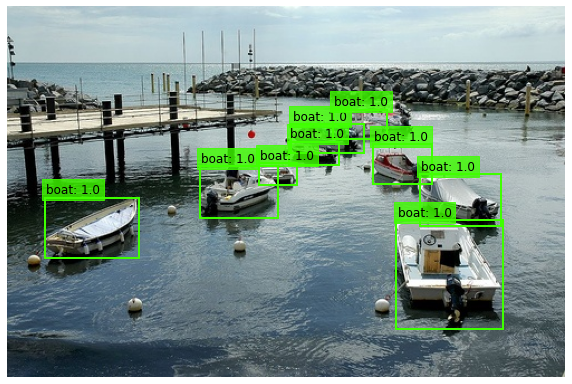

In [16]:
# Display random Image from the train set
display_random_image(trn_df)

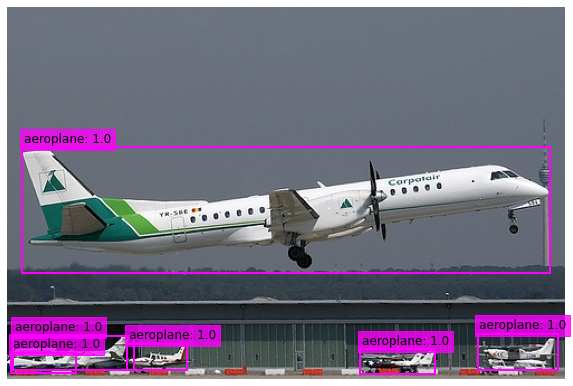

In [17]:
# Display random Image from the validation set
display_random_image(val_df)

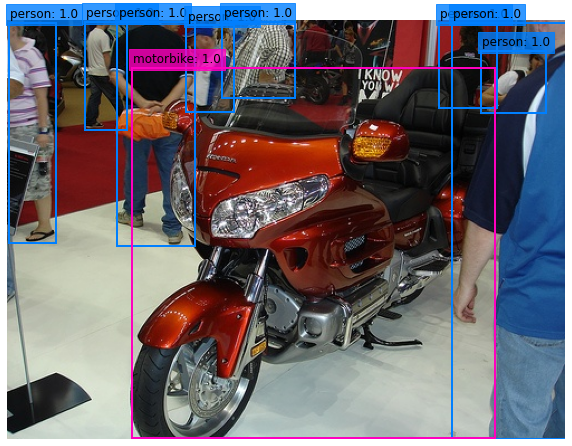

In [18]:
# Display random Image from the Test Dataset
display_random_image(tst_df)

**Instantiate `transforms`:**

In [19]:
def get_tfms() -> Dict[str, A.Compose]:
    "Returns a dictionary contatining transformations for train & valid/test datasets"
    # train transformations : [Modify this to add Transformations to train dataset] 
    trn_tfms = [
        A.HorizontalFlip(p=0.5),
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ]

    # validation transformations : [Transformations to the validation dataset]
    val_tfms = [
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ]

    # test transformations : [Transformations to the test dataset]
    tst_tfms = [
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),                
    ]

    # transforms dictionary :
    transforms = {
        "train": A.Compose(trn_tfms, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),),
        "valid": A.Compose(val_tfms, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),),
        "test" : A.Compose(tst_tfms, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),),
    }
    
    return transforms

**We will use `pytorch_lightning` to train our `PyTorch` model.**

**Create `pl.LightningModule` instance :** 

---
**Here we will instantiate a `pl.LightningModule` instance.**  

**The LightningModule holds all the core research ingredients:**
- The model
- The optimizers
- The train/ val/ test steps

In [20]:
# Create pl.LightningModule instance

# ========
# INFO :
# ========
# The hparams config file should contain the following (Required) :
# ========
# 1. optimizer : torch.optim.Optimizer -> Optimizer for the model
# 2. scheduler : Union[torch.optim.lr_scheduler, None] -> Scheduler for the Optimizer

# 3. trn_df    : pandas.DataFrame -> train dataframe
# 4. trn_bs    : int -> train batch_size

# 5. val_df    : pandas.DataFrame -> validation dataframe
# 6. val_bs    : int -> validation batch_size

# 7. test_df   :  pandas.DataFrame -> test dataframe
# 8. test_bs   : int -> test batch_size

# 9. iou_types : List -> for coco evaluation set it to ["bbox"].

class DetectionModel(pl.LightningModule):
    def __init__(self, model: nn.Module, hparams: argparse.Namespace) -> None:
        super(DetectionModel, self).__init__()
        self.model = model
        self.hparams = hparams

    @property
    def num_batches(self) -> List:
        "returns a list containing the number of batches in train, val & test dataloaders"
        return [len(self.train_dataloader()), len(self.val_dataloader()), len(self.test_dataloader())]

    ##################################################################
    ############## Configure Optimizer & Schedulers ##################
    ##################################################################
    def configure_optimizers(self, *args, **kwargs):
        "instatiates optimizer & scheduler(s)" 
        # optimizer
        optimizer = self.hparams.optimizer
        # scheduler
        scheduler = self.hparams.scheduler
        
        if scheduler is not None:
            return [optimizer], [scheduler]
        else:
            return [optimizer]

    ##################################################################
    ############# Forward Pass of the Model ##########################
    ##################################################################
    def forward(self, xb, *args, **kwargs):
        "forward step"
        return self.model(xb)

    ##################################################################
    ########################## preprare data #########################
    ##################################################################
    def setup(self, stage=None):
        'load in the transformation & read in the data from given paths'
        # Instantiate Transforms:
        self.tfms    = get_tfms()
        # Load in the DataFrames
        self.trn_df  = pd.read_csv(self.hparams.trn_df) # train dataframe
        self.val_df  = pd.read_csv(self.hparams.val_df) # valid dataframe
        self.test_df = pd.read_csv(self.hparams.test_df) # test dataframe

    ##################################################################
    ########################### Trainining ###########################
    ##################################################################
    def train_dataloader(self, *args, **kwargs):
        "instantiate train dataloader" 
        # instantiate the trian dataset
        train_ds = DetectionDataset(self.trn_df, self.tfms['train'])
        # load in the dataloader
        trn_dl = DataLoader(
            train_ds, batch_size=self.hparams.trn_bs, shuffle=True, collate_fn=collate_fn, pin_memory=True,
            )
        
        return trn_dl

    def training_step(self, batch, batch_idx, *args, **kwargs):
        "one training step"
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        return {"loss": losses, "log": loss_dict, "progress_bar": loss_dict}

    ##################################################################
    ###################### Validation ################################
    ##################################################################
    def val_dataloader(self, *args, **kwargs):
        "instatiate validation dataloader"
        # instantiate the validaiton dataset
        val_ds = DetectionDataset(self.val_df, self.tfms['valid'])
        # instantiate dataloader
        loader = DataLoader(val_ds, batch_size=self.hparams.val_bs, shuffle=False, collate_fn=collate_fn,)
        # instantiate coco_api to track metrics
        coco = get_coco_api_from_dataset(loader.dataset)
        self.coco_evaluator = CocoEvaluator(coco, self.hparams.iou_types)
        return loader

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        "one validation step"
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        self.coco_evaluator.update(res)
        return {}

    def validation_epoch_end(self, outputs, *args, **kwargs):
        self.coco_evaluator.accumulate()
        self.coco_evaluator.summarize()
        metric = self.coco_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        logs = {"valid_mAP": metric}
        return {"valid_mAP": metric, "log": logs, "progress_bar": logs,}
    
    ##################################################################
    ######################## Test ####################################
    ##################################################################
    def test_dataloader(self, *args, **kwargs):
        "instatiate validation dataloader"
        # instantiate train dataset
        test_ds = DetectionDataset(self.test_df, self.tfms['test'])
        # instantiate dataloader
        loader = DataLoader(test_ds, batch_size=self.hparams.test_bs, shuffle=False, collate_fn=collate_fn,)
        # instantiate coco_api to track metrics
        coco = get_coco_api_from_dataset(loader.dataset)
        self.test_evaluator = CocoEvaluator(coco, self.hparams.iou_types)
        return loader

    def test_step(self, batch, batch_idx, *args, **kwargs):
        "one test step"
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        self.test_evaluator.update(res)
        return {}
    
    def test_epoch_end(self, outputs, *args, **kwargs):
        self.test_evaluator.accumulate()
        self.test_evaluator.summarize()
        metric = self.test_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        logs = {"test_mAP": metric}
        return {"test_mAP": metric, "log": logs, "progress_bar": logs,}

```bash
To train a LightningModule we need to a Trainer from PyTorch Lightning.
```

**Configure `LightningModule` and `Trainer` Configurations:** 

In this part we will create set up our trainining configuration for both the LightningModule & the Trainer.


**Configuration for `LightningModule`:**

In [21]:
## Configurations for `LightningModule`

# ==================================================================================== #
# Instantiate model
# ==================================================================================== #
NUM_CLASSES = 20 # Total number of unique Targets
BACKBONE = 'resnet50' # backbone for RetinaNet Model
# load in the RetinaNet model
model = Retinanet(num_classes=NUM_CLASSES, backbone_kind=BACKBONE, freeze_bn=True, max_size=1333, min_size=800)

# ==================================================================================== #
# Parameters for the Train, Validation & the Test Data
# ==================================================================================== #
# Train dataset Parametrs:
trn_df = trn_csv_dir # path 2 dataframe
trn_bs = 2 # batch_size

# Valid dataset parametrs:
val_df = val_csv_dir # path 2 dataframe
val_bs = 2 # batch_size

# Test dataset parametrs:
test_df = tst_csv_dir # path 2 dataframe
test_bs = 2 # batch_size

# ==================================================================================== #
# Optimizer & Scheduler Patameters
# ==================================================================================== #
LR = 1e-03
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.9
params = [p for p in model.parameters() if p.requires_grad] # model parameters to train
# Instantiate Optimizer
optimizer = SGD(params, LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
# Instantiate scheduler
# Note: If no scheduler is used set scheduler to None
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[16, 25], gamma=0.1)
# convert scheduler to lightning format
if scheduler is not None:
    INTERVAL = "epoch" # scheduler interval wether after each 'step' for each 'epoch'
    scheduler = {"scheduler": scheduler, "interval": INTERVAL , "frequency": 1,}

# ==================================================================================== #
# set iou types:
# ==================================================================================== #
iou_types = ['bbox'] # Required for COCO eval


# ===================================================================================== #
# Create Dictionary to Store the arguments:
# ===================================================================================== #
hparams_dict = {
    'optimizer'     : optimizer,
    'scheduler'     : scheduler,
    'trn_df'        : trn_df,
    'trn_bs'        : trn_bs,
    'val_df'        : val_df,
    'val_bs'        : val_bs,
    'test_df'       : test_df,
    'test_bs'       : test_bs,
    'iou_types'     : iou_types,
}


# ===================================================================================== #
# Convert dictionary to `Namespace` it is then easier to load from checkpoint
# ===================================================================================== #
hparams= argparse.Namespace(**hparams_dict)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


**Configuration for `pl.Trainer`:**

In [22]:
## Create configurations for the Trainer Flags :

# ===================================================================================== #
# Number of Epochs to Train for :
# ===================================================================================== #
EPOCHS = 40 # set number of epochs to Train for

# ===================================================================================== #
# Insantiate Logger to Log Training logs :
# ===================================================================================== #
# Wandb logger: assuming wandb is set-up [Optional]
wb_name = f"{time.strftime('%d-%m-||-%I.%M.%S%-p')}" # change the run name here
wb_p = "pascal-2007" # change the project name here
wb_logger = WandbLogger(name=wb_name, project=wb_p, anonymous="allow",)

# learning_rate logger:
lr_logger = LearningRateLogger(logging_interval="step") # we use this to log the learning rate

# setup callbacks & loggers into a list
# since pl.Trainer expects them to be in a list format
logger=[wb_logger]
callbacks=[lr_logger]


# ===================================================================================== #
# Insantiate CheckPoint Callback :
# ===================================================================================== #
# checkpoint callback will save the top 2 checkpoints
# path to the directory where to save the checkpoints
fname = "/content/drive/My Drive/checkpoints-pascal/"
os.makedirs(fname, exist_ok=True)
checkpoint_callback = ModelCheckpoint(fname, mode="max", monitor="valid_mAP", save_top_k=2,)

# ===================================================================================== #
# Insantiate EarlyStopping Callback :
# ===================================================================================== #
early_stop_callback = EarlyStopping(mode="max", monitor="valid_mAP", patience=5,)

# ===================================================================================== #
#  Additional Trainer Flags:
# ===================================================================================== #
check_val_every_n_epoch = 10 # Validaiton Check Interval
gpus = 1  # gpus to use
precision = 16 # precision

# ===================================================================================== #
# Create Dictionary to the Trainer Flags:
# ===================================================================================== #
trainer_config_dict = {
    'num_sanity_val_steps'   : 0,
    'benchmark'              : True, # Set benchmark True to get better performance
    'logger'                 : logger,
    'callbacks'              : callbacks,
    'checkpoint_callback'    : checkpoint_callback,
    'early_stop_callback'    : early_stop_callback,
    'gpus'                   : gpus,
    'precision'              : precision,
    'max_epochs'             : EPOCHS,
    'check_val_every_n_epoch': check_val_every_n_epoch,
}

# ===================================================================================== #
# Convert dictionary to `Namespace`
# ===================================================================================== #
trainer_config = argparse.Namespace(**trainer_config_dict)

**Load trainer & model from the configuration files:**

In [23]:
## Load in lightning module from the scpecified hparams
retinanet = DetectionModel(model, hparams)

## Load in trainer using trainer configs
trainer = pl.Trainer.from_argparse_args(trainer_config)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


**Train:**

---

**Fit retinanet on the train data:**

In [24]:
# Fit Model
trainer.fit(retinanet)


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 36 M  


creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.889
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.901
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Saving latest checkpoint..


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.890
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

1

**Test:**

---
**Evaluate trained model on the test dataset:**

In [25]:
# Evaluate model on test dataloader
trainer.test()

creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

[{'test_mAP': 0.3373837383738373}]

**Save model weights:**

In [27]:
## Set fname to the path where the model should be saved
fname="/content/drive/My Drive/checkpoints-pascal/voc_2007.pt"

torch.save(retinanet.model.state_dict(), fname)

**Inference:**

---

**Imports & helper functions for inference::**

In [28]:
from google.colab import files

# Transformations for the Inference Image:
infer_tfms = A.Compose([A.ToFloat(max_value=255.0, always_apply=True), ToTensorV2(always_apply=True),])

**Path to where the weights are saved:**

In [29]:
## Path to the saved weights file
weights_file = "/content/drive/My Drive/checkpoints-pascal/voc_2007.pt"

**Helper Functions:**

In [37]:
# ===================================================================================== #
# Get Image Predictions :
# ===================================================================================== #
@torch.no_grad()
def get_preds(path, threshold=0.5, iou_threshold=0.5, fname=weights_file, device='cpu') -> Tuple[List, List, List]:
    "Get predictions on image" 
    ## Parameters to Load in the Model
    param_dict = {
        'num_classes'  : NUM_CLASSES,
        'backbone_kind': BACKBONE,
        'score_thres'  : threshold,
        'nms_thres'    : iou_threshold,
    }

    # Instantiate the model
    model = Retinanet(**param_dict)
    # Load in the pretrained model weights from weights file
    model.load_state_dict(torch.load(fname))
    model.to(device) # inference can be done on CPU
    model.eval() # Set model to eval mode to get bbox predicitons
    # Load in the given immage fromm the Image Path
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    # Process the image
    img = infer_tfms(image=img)["image"]
    img = img.to(device)
    # Generate predictions
    pred = model([img])
    # Unpack predictions
    pred_boxes,pred_class,pred_score = pred[0]["boxes"],pred[0]["labels"],pred[0]["scores"]
    # Convert predictions to list
    boxes = list(pred_boxes.cpu().numpy())
    clas = list(pred_class.cpu().numpy())
    scores = list(pred_score.cpu().numpy())
    return boxes, clas, scores

# ===================================================================================== #
# Load Image and Draw predicted bounding box over the Image :
# ===================================================================================== #
## Fuction to load in the Image , get bbounding-box predictions
## and draw the bounding box predictions over the Image.
def object_detection_api(img_path=None, device='cpu', sc_thrs=0.5, iou_thres=0.5) -> None:
    "Draw bbox predictions on given image at img_pth"
    # if Image path is not Given load image path from the user
    if img_path is None:
        uploaded = files.upload()
        img_path = list(uploaded.keys())[0]

    bb, cls, sc = get_preds(img_path, sc_thrs, iou_thres, device=device,)

    # Load in the Image and draw the predicted bboxes over it
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    viz.draw_bboxes(img, boxes=bb, classes=cls, scores=sc)

**Test model predictions:**

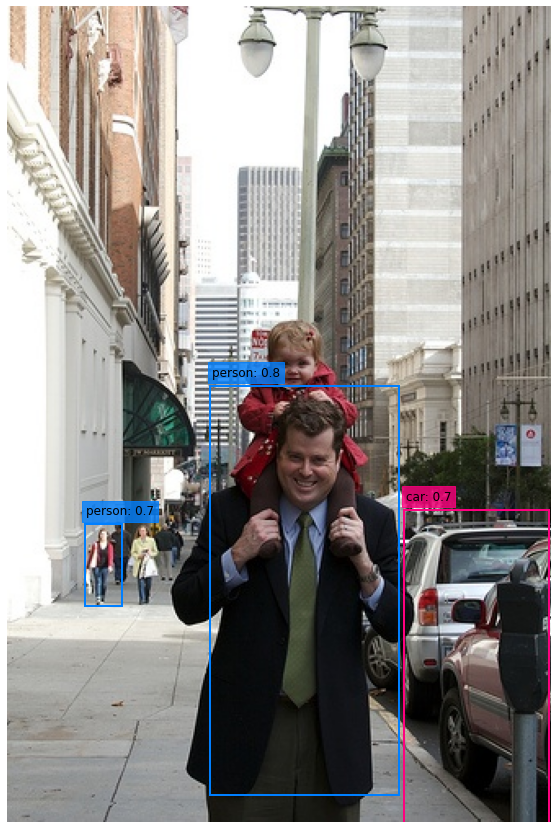

In [43]:
idx = np.random.randint(0, len(tst_df)) # Grab the Id of a random image fromm the Test Dataset
# Detect Objects in the Given Image
object_detection_api(device='cuda:0', sc_thrs=0.6, iou_thres=0.3, img_path=tst_df["filename"][idx],)

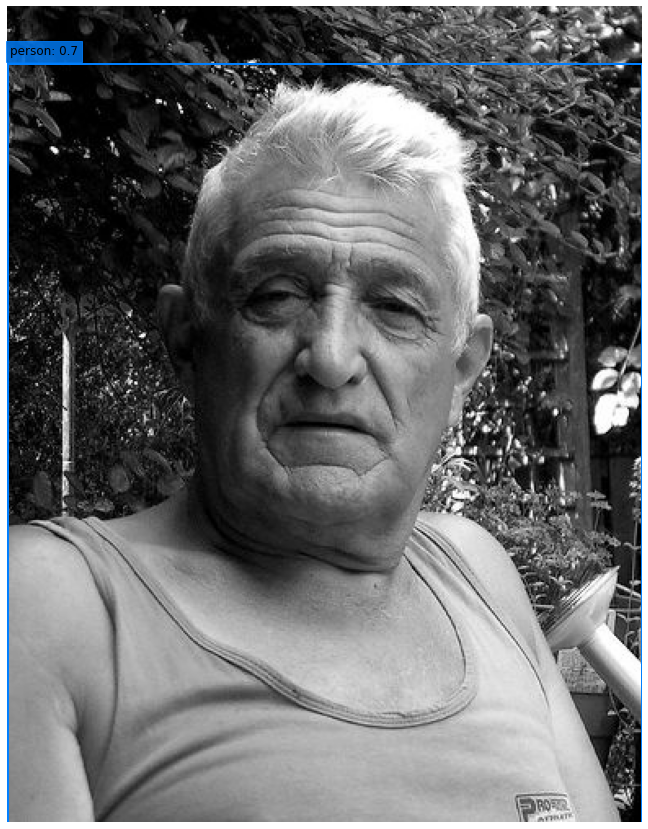

In [44]:
idx = np.random.randint(0, len(tst_df)) # Grab the Id of a random image fromm the Test Dataset
# Detect Objects in the Given Image
object_detection_api(device='cuda:0', sc_thrs=0.6, iou_thres=0.3, img_path=tst_df["filename"][idx],)

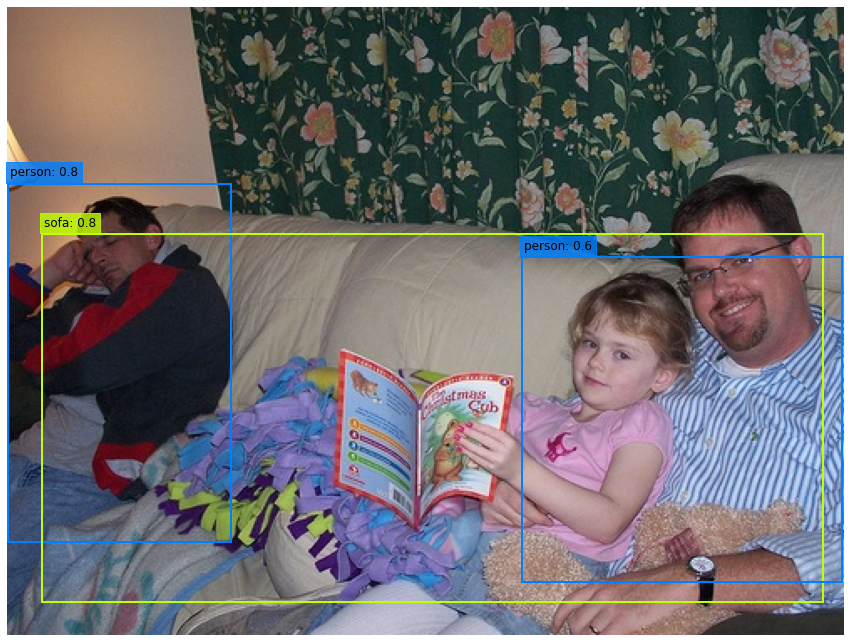

In [45]:
idx = np.random.randint(0, len(tst_df)) # Grab the Id of a random image fromm the Test Dataset
# Detect Objects in the Given Image
object_detection_api(device='cuda:0', sc_thrs=0.6, iou_thres=0.3, img_path=tst_df["filename"][idx],)

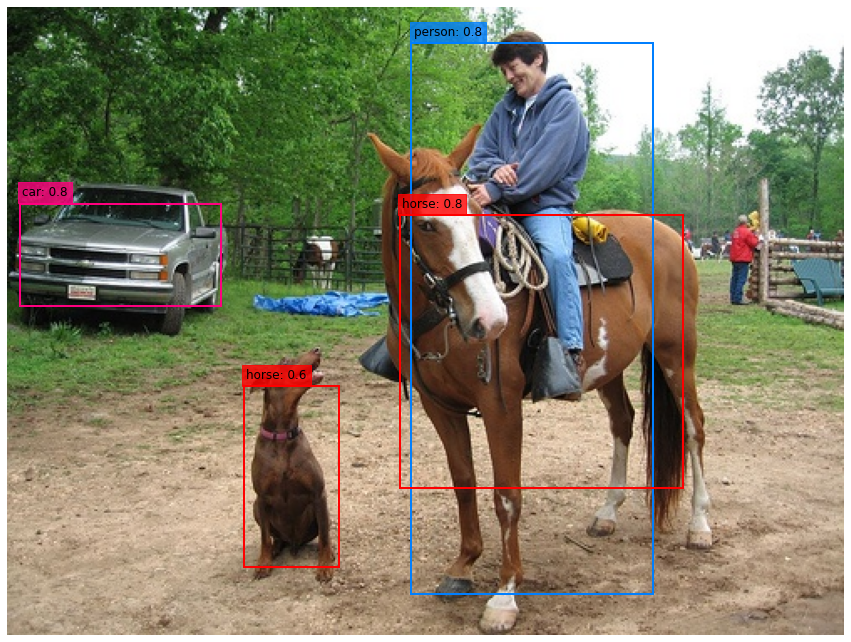

In [46]:
idx = np.random.randint(0, len(tst_df)) # Grab the Id of a random image fromm the Test Dataset
# Detect Objects in the Given Image
object_detection_api(device='cuda:0', sc_thrs=0.6, iou_thres=0.3, img_path=tst_df["filename"][idx],)